### Tuning hyper-paremter of BG cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [4]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  20 files
Extracted: 20 files


In [5]:
# Importing in neghbouring cells info (numbers)

# with open(nnb_path + nnb_training) as f: 
#     nb_mylist= f.read().splitlines()
    
# print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")
nb_mylist = [i[0:6]+'_all_neighbours.csv' for i in mylist]
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 20  NUMBER OF neighbouring cells files
Extracted: 20 files
no. of columns / NB file: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 13]


In [6]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
# with open(hema_path + hema_training) as f: 
#     hema_mylist= f.read().splitlines()
    
# print("Read in:",len(hema_mylist),"hema files")
hema_mylist = [i[0:6]+'_hema.csv' for i in mylist]    
print("Read in:",len(hema_mylist),"hema files")   


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 20 hema files
Extracted: 20 hema files


In [7]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[0:6] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [8]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB2(annotated_list = inputs,
                                                        NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [9]:
nb_inputs[0].columns

Index(['X', 'Y', 'NN_10_um', 'NN_20_um', 'NN_30_um', 'NN_40_um', 'NN_50_um',
       'NN_60_um', 'NN_70_um', 'NN_80_um', 'NN_90_um', 'NN_100_um',
       'NN_110_um', 'NN_120_um', 'NN_130_um', 'NN_140_um', 'NN_150_um',
       'slice_id'],
      dtype='object')

In [10]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [11]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
(89, 56)


### Putting the slides together 

In [12]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI', 'NN_110_um', 'NN_120_um', 'NN_130_um', 'NN_140_um', 'NN_150_um']) 
dat.head()


(1694, 56)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,721708.svs,Oligo,12022.2,8715.8,0.8575,13.1628,13.2907,0.9364,1.0,4.9150,...,1,1,2,7,10,15,22,30,37,50
1,721708.svs,Oligo,12029.8,8722.0,0.8796,15.2611,14.0081,0.9773,1.0,4.7992,...,1,1,1,4,10,17,24,34,38,49
2,721708.svs,Oligo,10048.5,9974.4,0.8670,16.7321,14.7662,0.9643,1.0,5.0758,...,1,3,5,7,11,14,25,35,52,65
3,721708.svs,Oligo,10029.8,9984.5,0.8827,18.6383,15.5263,0.9716,1.0,5.3159,...,1,1,4,6,9,17,26,36,47,63
4,721708.svs,Oligo,10031.0,9993.5,0.8682,21.4955,16.7517,0.9626,1.0,5.7030,...,1,1,4,6,11,18,24,35,49,64


### Extracting relevant cell classes

In [13]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

oligo              783
endo               289
neuron             200
astro              187
ignore             142
epi                 28
fragmented          27
ambiguous           22
tuftedastrocyte     13
tumor                2
neuronaltau          1
Name: Class, dtype: int64

In [14]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo') | (dat2['Class'] == 'neuron')
          | (dat2['Class'] == 'astro')| (dat2['Class'] == 'epithelial')
          | (dat2['Class'] == 'ignore')| (dat2['Class'] == 'fragmented')| (dat2['Class'] == 'endo')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

oligo         783
endo          289
neuron        200
astro         187
ignore        142
fragmented     27
Name: Class, dtype: int64

In [15]:
cell_code = {'neuron':'Neuron',
             'oligo': 'Oligo',
             'ignore': 'Others',
             'astro':'Astro',
             'epithelial':'Others',
             'endo':'Others',
             'fragmented':'Others'}

In [16]:
# 3) Changing Epithelial to Endothelial
classes = dat3['Class']
formatted_classes = [cell_code[i]  for i in classes]
data = dat3.copy()
data.loc[:,'Class']=formatted_classes

In [17]:

data['Class'].value_counts()

Oligo     783
Others    458
Neuron    200
Astro     187
Name: Class, dtype: int64

In [18]:
# Export cleaned data out for easy use: 
# path = '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Cell_classification/bg_training_data.txt'
# data.to_csv(path, sep="\t", index=False)

# Training the model

### Checking for any NA in the data

In [19]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

#dat = dat.dropna()
#dat.isnull().sum().sum()

Any NA in the data?:  False


### Create train, test sets 

In [20]:
#We are using the entire dataset to train the model, test data will be provided later by Sanne 
X_train_l = data.drop(columns=['Class'])
X_train = X_train_l.drop(columns=['Image','Centroid_X','Centroid_Y'])
print('training data shape:',X_train.shape)
y_train = data['Class']

training data shape: (1628, 44)


In [21]:
X_train.head()

,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,Nucleus: Min diameter µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,0.8575,13.1628,13.2907,0.9364,1.0,4.9150,3.4944,103.1323,37.8404,0.9051,...,1,1,2,7,10,15,22,30,37,50
1,0.8796,15.2611,14.0081,0.9773,1.0,4.7992,4.1628,120.9785,40.6755,0.9189,...,1,1,1,4,10,17,24,34,38,49
2,0.8670,16.7321,14.7662,0.9643,1.0,5.0758,4.3099,100.9326,38.6687,0.8482,...,1,3,5,7,11,14,25,35,52,65
3,0.8827,18.6383,15.5263,0.9716,1.0,5.3159,4.4388,124.4651,42.9339,0.8485,...,1,1,4,6,9,17,26,36,47,63
4,0.8682,21.4955,16.7517,0.9626,1.0,5.7030,5.0028,136.2816,44.2523,0.8745,...,1,1,4,6,11,18,24,35,49,64


In [22]:
pipeline_cell

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42))),
                ('clf', BalancedRandomForestClassifier())])

### Hyperparameter tuning - random forest

In [23]:
# # Create the random grid 

rf_random = GridSearchCV(pipeline_cell_linearSVM,
                         param_grid=grid_linearSVM, 
                        cv=10,
                        refit='f1_macro', # use this metric to evaluate performance of parameters 
                        scoring={
                        'balanced_accuracy':'balanced_accuracy',
                        'f1_macro':'f1_macro',
                          'f1_weighted':'f1_weighted',
                          'Astro_accuracy': astro_acc,
                          'Neuron_accuracy':neuron_acc,
                          'Oligo_accuracy':oligo_acc,
                          'Others_accuracy':others_acc,
                          'A_as_N':A_as_N,
                          'A_as_O':A_as_O,
                          'A_as_Others':A_as_Others,
                          'N_as_A':N_as_A,
                          'N_as_O':N_as_O,
                          'N_as_Others':N_as_Others,
                          'O_as_A':O_as_A,
                          'O_as_N':O_as_N,
                          'O_as_Others':O_as_Others,
                          'Others_as_A':Others_as_A,
                          'Others_as_N':Others_as_N,
                          'Others_as_O':Others_as_O
                        })

rf_random.fit(X_train,y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)


0.7686625586234264
{'clf__C': 10, 'clf__class_weight': 'balanced', 'selector__n_features_to_select': 36}


In [25]:
# # Digging into more details 

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_macro:",
      rf_random.cv_results_['mean_test_f1_macro'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Astrocyte accuracy:",
      rf_random.cv_results_['mean_test_Astro_accuracy'][rf_random.best_index_]*100)

print("Neuron accuracy:",
      rf_random.cv_results_['mean_test_Neuron_accuracy'][rf_random.best_index_]*100)

print("Oligo accuracy:",
      rf_random.cv_results_['mean_test_Oligo_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)


print("Classified A as N:",
      rf_random.cv_results_['mean_test_A_as_N'][rf_random.best_index_]*100)

print("Classified A as O:",
      rf_random.cv_results_['mean_test_A_as_O'][rf_random.best_index_]*100)

print("Classified A as Others:",
      rf_random.cv_results_['mean_test_A_as_Others'][rf_random.best_index_]*100)

print("Classified N as A:",
      rf_random.cv_results_['mean_test_N_as_A'][rf_random.best_index_]*100)

print("Classified N as O:",
      rf_random.cv_results_['mean_test_N_as_O'][rf_random.best_index_]*100)

print("Classified N as Others:",
      rf_random.cv_results_['mean_test_N_as_Others'][rf_random.best_index_]*100)

print("Classified O as A:",
      rf_random.cv_results_['mean_test_O_as_A'][rf_random.best_index_]*100)

print("Classified O as N:",
      rf_random.cv_results_['mean_test_O_as_N'][rf_random.best_index_]*100)

print("Classified O as Others:",
      rf_random.cv_results_['mean_test_O_as_Others'][rf_random.best_index_]*100)


print("Classified Others as A:",
      rf_random.cv_results_['mean_test_Others_as_A'][rf_random.best_index_]*100)

print("Classified Others as N:",
      rf_random.cv_results_['mean_test_Others_as_N'][rf_random.best_index_]*100)

print("Classified Others as O:",
      rf_random.cv_results_['mean_test_Others_as_O'][rf_random.best_index_]*100)
                                                       

Balanced accuracy: 78.88268421201177
F1_macro: 76.86625586234264
F1_weighted: 82.02983712255568
Astrocyte accuracy: 69.06432748538013
Neuron accuracy: 82.5
Oligo accuracy: 86.69587796170075
Others accuracy: 77.27053140096618
Classified A as N: 15.497076023391815
Classified A as O: 4.7368421052631575
Classified A as Others: 10.701754385964913
Classified N as A: 11.500000000000002
Classified N as O: 0.5
Classified N as Others: 5.500000000000001
Classified O as A: 6.652061019149627
Classified O as N: 0.0
Classified O as Others: 6.652061019149627
Classified Others as A: 9.400966183574878
Classified Others as N: 5.879227053140096
Classified Others as O: 7.44927536231884


In [26]:
# save object using joblib
joblib.dump(rf_random, 'BG_linear_SVM_gridSearch.sav')

['BG_linear_SVM_gridSearch.sav']

## Manual cross validation, using PR curves

In [27]:
BG_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(estimator=SVC(random_state=42,
                                   kernel='linear'),
        n_features_to_select=36)),
    ('clf', SVC(
        random_state=42,
        kernel='linear',
        C=10,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = ClassifierTuning(hyperparameters=BG_classifier_hyperparams)


In [28]:
model.cv_nothresholding(X=X_train,
                        Y=y_train,
                        X_location= X_train_l)

In [29]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("Astro accuracy",final_cm[0][0])
print("Neuron accuracy",final_cm[1][1])
print("Oligo accuracy",final_cm[2][2])
print("Others accuracy",final_cm[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reports])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reports])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reports])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reports])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reports])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reports])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 78.88268421201177
Macro avg F1  76.86625586234263
Weighted avg F1  82.02983712255568
--------------------------
[[129  29   9  20]
 [ 23 165   1  11]
 [ 52   0 679  52]
 [ 43  27  34 354]]
[[68.98395722 15.50802139  4.81283422 10.69518717]
 [11.5        82.5         0.5         5.5       ]
 [ 6.64112388  0.         86.71775223  6.64112388]
 [ 9.38864629  5.89519651  7.42358079 77.29257642]]
--------------------------
Astro accuracy 68.98395721925134
Neuron accuracy 82.5
Oligo accuracy 86.71775223499361
Others accuracy 77.29257641921397
------------------------------
Astro f1-score  60.55845134993073
Astro precision  54.65953030569736
Astro recall  69.06432748538012
--------------------------
Neuron f1-score  77.872917891844
Neuron precision  76.03897817158686
Neuron recall  82.5
--------------------------
Oligo f1-score  89.95736447534483
Oligo precision  93.93375157409754
Oligo recall  86.69587796170075
--------------------------
Others f1-score  79.0762897322509

In [30]:
# save object using joblib
joblib.dump(model, 'bg_linear_SVM_cv_results.sav')

['bg_linear_SVM_cv_results.sav']

Train the final model

In [32]:
# Train final model
bg_model = Pipeline(BG_classifier_hyperparams)
final_model = bg_model.fit(X_train,y_train)

In [33]:
joblib.dump(final_model, 'bg_linear_SVM_classifier.sav')

['bg_linear_SVM_classifier.sav']

Extracting information

In [35]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/BG/bg_linear_SVM_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matrices)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

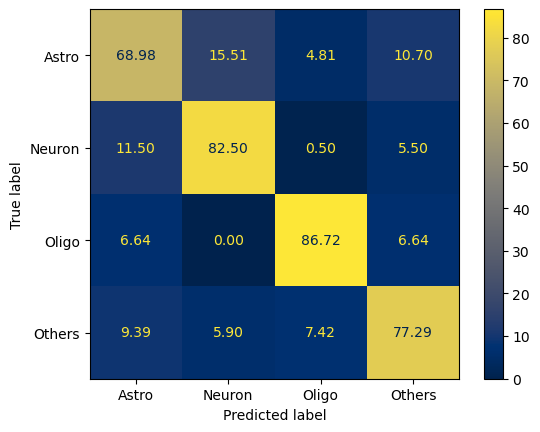

In [36]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['Astro', 'Neuron', 'Oligo', 'Others'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [37]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  76.86625586234263
Macro avg F1 std  6.242033580384383
--------------------------
Macro avg precision 76.48937422151914
Macro avg precision std 6.001540194887519
--------------------------
Macro avg recall  78.88268421201177
Macro avg recall std 6.005672616395812


Plotting feature importance

In [39]:
import seaborn as sns

In [38]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/BG/bg_linear_SVM_gridSearch.sav')

In [40]:
model_rf.best_params_

{'clf__C': 10,
 'clf__class_weight': 'balanced',
 'selector__n_features_to_select': 36}

In [41]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [X_train.columns[i] for i in rf_result]
(rf_result_f)

['Detection probability',
 'Nucleus: Area µm^2',
 'Nucleus: Length µm',
 'Nucleus: Circularity',
 'Nucleus: Solidity',
 'Nucleus: Max diameter µm',
 'Nucleus: Min diameter µm',
 'Cell: Area µm^2',
 'Cell: Length µm',
 'Cell: Circularity',
 'Cell: Solidity',
 'Cell: Max diameter µm',
 'Cell: Min diameter µm',
 'Nucleus/Cell area ratio',
 'Hematoxylin: Nucleus: Mean',
 'Hematoxylin: Nucleus: Median',
 'Hematoxylin: Nucleus: Min',
 'Hematoxylin: Nucleus: Max',
 'Hematoxylin: Nucleus: Std.Dev.',
 'Hematoxylin: Cytoplasm: Mean',
 'Hematoxylin: Cytoplasm: Min',
 'Hematoxylin: Cytoplasm: Max',
 'Hematoxylin: Cytoplasm: Std.Dev.',
 'Hematoxylin: Membrane: Mean',
 'Hematoxylin: Membrane: Min',
 'Hematoxylin: Membrane: Std.Dev.',
 'Hematoxylin: Cell: Mean',
 'Hematoxylin: Cell: Median',
 'Hematoxylin: Cell: Min',
 'Hematoxylin: Cell: Max',
 'Hematoxylin: Cell: Std.Dev.',
 'NN_10_um',
 'NN_20_um',
 'NN_40_um',
 'NN_50_um',
 'NN_90_um']